# **NSFW Classifier - Improving the baseline**

## **Purpose**

In the previous notebook, we obtained a baseline for NSFW classification by fine tuning a pretrained ResNet50 model during 5 epochs on a custom dataset containing ~4900 images.

The accuracy obtained in this way was ~92.5%. While the training loss decreased smoothly, the model showed early signs of overfitting. Displaying the "worst" misclassified images made it obvious that the dataset could greatly benefit from cleaning as it contained many mislabeled images, as well as pictures of text and other irrelevant image content.

This notebook is the first of three experiments that aim to improve the model over the baseline in regards to accuracy and overfitting:

1. **Experiment 1:** New baseline with a cleaned, extended dataset. Goal: improve accuracy.
2. **Experiment 2:** New baseline with the old dataset + data augmentation. Goal: reduce overfitting.
3. **Experiment 3:** New baseline with the cleaned, extended dataset + data augmentation. Goals: improve accuracy and reduce overfitting.

Experiments 2 and 3 are published in separate notebooks. The methodology for all three experiments, as well as a summary of the results are detailed here.

## **Methodology**

### 1. Cleaning the dataset

The dataset was cleaned by removing the following types of images:

- Mislabeled images
- Images with > 20% text overlays
- Screenshots of Twitter, Instagram, Facebook, etc. posts
- Memes
- NSFW images pertaining to non-sexual, non-nude categories, e.g. gore, violence, bodily harm, etc. 
- Truncated images

To make up for the deleted images and with the aim of reaching a dataset size of ~6000 total images, a further 1000 images of each category were downloaded and cleaned, thus obtaining a final dataset containing 3059 NSFW and 3110 SFW images (6169 total).

### 2. Data augmentation

Data augmentation was performed by resizing the images to 460 x 460 px, and then applying a series of of flip, rotate, zoom, warp, and lighting transforms using Fastai's utility function `aug_transforms()`:

```
aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=224, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=0.75)
```

Note that the images are again resized during data transforms to end up being 224 x 224 px, the input format required by ResNet50.

The reason for resizing the images to a relatively large size before applying any transforms is that this avoids problems such as ending up with empty patches in the corners following a rotation.

The transforms are applied in batch, making them very fast when using a GPU runtime. 

## **Results**

| Experiment | Accuracy | Overfitting | Observations
| --- | --- | --- | ---
| Baseline | 92.5% | Early | Many mislabeled images, overall noisy dataset
| Cleaning | 95.3% | Early | There are still many mislabeled images in the dataset
| Data Augmentation | 94.3% | Later | Dataset is as noisy as the one used for the baseline
| Cleaning + Data Augmentation | 96.0% | Later| Some misclassified images represent more "difficult" examples - e.g. non-sexual partial nudity (bikini)

## **Ideas for further improvement**

### 1. Dataset improvement

The dataset used so far is good enough for initial experimentation. However, having sifted through it image-by-image, I've become aware of some major flaws:

- Male nudity, certain age groups, larger body sizes, and non-caucasian ethnicities are all underrepresented
- Most images are user-generated content posted on reddit and tumblr 
- Sex scenes, as opposed to people posing alone, are underrepresented

My first priority would therefore be to increase the diversity of image sources, as well as address the problem of underrepresented demographic groups. Additionally, I'd try to obtain the NPDI dataset commonly used for benchmarking in the scientific literature, as discussed in the Datasets report.

In terms of dataset size, I would aim for 10-20k total images as that seems doable both in terms of training time on GPU, Google Drive storage space, and the time it takes to clean the data image-by-image.

So far, I have been using a 80/20 train/validate split in all experiments. For the time being, I haven't needed an additional test set as the need to generalize to unseen data hasn't been addressed yet. This is however something that should be added. Ideally, the test set would be constructed by someone else than myself to avoid bias.

### 2. Regularization

While performance is good on the training data, with training loss converging smoothly and nearing the Bayes error toward the end of training, the validation loss stalls and diverges quite early on.

Getting more data could help with overfitting. Realistically, there's a limit to the max size of the dataset I could use in practice due to space and training time constraints, and even at this max size, the model's representational capacity would still be too big in comparison, resulting in low bias (good) and high variance (bad), as evidenced by overfitting.

The solution then could be to decrease model capacity by using techniques such as L2 and/or drop-out regularization, possibly with the addition of early stopping. 

### 3. Hyperparameter tuning

So far, all experiments have been conducted using Adam as the optimizer, a constant learning rate of 0.003, and mini-batches of size 64.

These, as well as other hyperparameters, can all be fine tuned. My approach here would be to use random search, rather than grid search, and use Fastai/PyTorch for prototyping to increase iteration speed. 

### 4. Model architecture

If time allows, I would like to try out some methods I've come across in the scientific literature during the research phase of this project:

- Substituting the last pooling layer with a Spatial Pyramid Pooling layer (SPP) to allow for variable input sizes, thus avoiding cropping/warping the images to fit ResNet50's required input size (224 x 224). 
- USE an SVM instead of Softmax as the output layer.
- Adding an Attention module to the architecture.
- Adding a pre-processing module to make the model robust against adversarial attacks.

## **Conclusions**

Transfer learning with ResNet50 shows promising preliminary results in developing an NSFW classifier. The next steps in development would be improving and extending the existing dataset, as well as adding regularization to reduce overfitting.

The rest of this notebook, as well as the other notebooks containing the experiments mentioned here are "bare-bones" code, as all relevant methodology and results have already been discussed here. 

## Setting up the environment

In [ ]:
# Setup Fastai Colab environment
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.all import *
import os

# Some files got mildly corruped during upload to Google Drive.
# This helps avoids some problems down the line
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Set random seed for reproducibility

seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [ ]:
# Verify image folder location
os.listdir("../content/gdrive/My Drive/Datasets")

['NSFW', 'SFW']

In [ ]:
# Create Path object to image folders
path=Path("../content/gdrive/My Drive/Datasets")
path.ls()

(#2) [Path('../content/gdrive/My Drive/Datasets/NSFW'),Path('../content/gdrive/My Drive/Datasets/SFW')]

In [ ]:
print('total NSFW images:', len(os.listdir(os.path.join(path, "NSFW"))))
print('total SFW images:', len(os.listdir(os.path.join(path, "SFW"))))

total NSFW images: 3059
total SFW images: 3110


## Setting up the image dataloader

In [ ]:
# Define input params for data block 

# This sets up a train/validate split of 80/20
splitter=RandomSplitter(valid_pct=0.2, seed=seed) 
# ResNet50 requires an input size of (224, 224, 3)
item_tfms = [Resize(224)] 

In [ ]:
# Create blueprint for dataloader
data_block = DataBlock(
                  blocks=[ImageBlock, CategoryBlock],
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=splitter,
                  item_tfms=item_tfms)

In [ ]:
# Create dataloader with batch size = 64 
dls = data_block.dataloaders(path, bs=64)

In [ ]:
# Run this cell at your own peril!
dls.show_batch()

## Training 

In [ ]:
# Prevents getting disconnected, use only when training in Colab
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
# Instantiate a pre-trained model 
learn = cnn_learner(dls, resnet50, metrics=accuracy)
# Train for 5 epochs
learn.fine_tune(5, 3e-3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.373216,0.197624,0.934307,17:01


epoch,train_loss,valid_loss,accuracy,time
0,0.213549,0.150637,0.947283,01:45
1,0.126702,0.191907,0.935118,01:45
2,0.083098,0.174107,0.946472,01:45
3,0.043833,0.164838,0.956204,01:45
4,0.022807,0.169441,0.952960,01:45


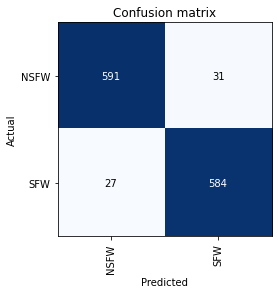

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Only for the brave! 
interp.plot_top_losses(9, nrows=3)